# Porcupine Neural Networks

Experiment: 

1. Get true labels using fully connected networks
2. Only update along direction (lines) of initialization. i.e. project gradients along initialized line (for d inputs, there are d weights for each hidden neuron and hence a d-dimensional line).

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,seaborn,pickle
import matplotlib.pyplot as plt
import arch,dl_utils,utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 1

%matplotlib inline

maindir = './temp_PNN/'

In [2]:
# Same as graph_builder_wrapper except for sparser structures
# CURRENTLY ONLY WORKS WITH mlp_noreluout_lastlayernottrainable
# (M is a mask for only the weights from input to hidden 1 layers)
def graph_builder_wrapper_PNN(input_dict,build_func=arch.mlp,lr_initial=0.01,max_save=100):
    graph = build_func(input_dict)
    
    # Loss
    y = tf.placeholder(tf.float32, shape=[None,1])
    total_loss = dl_utils.loss(y, graph['yhat'])
    
    # W gap
    w = {k:tf.placeholder(tf.float32, shape=[None,None]) for k in graph if 'weights' in k}
    total_w_gap = dl_utils.w_gap(w, {k:graph[k] for k in graph if 'weights' in k})
    
    # Find unit vectors
    u = graph['weights1'] / tf.sqrt(tf.reduce_sum(tf.square(graph['weights1']), 0, keep_dims=True))
    
    # Optimizer
    learning_rate = tf.Variable(lr_initial, name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(total_loss)
    modified_grads = []
    for gv in grads:
        if gv[0] is None: modified_grads.append(gv)
        else: 
            # Project gradients along unit vectors
            alpha = tf.diag_part(tf.matmul(tf.transpose(u),gv[0]))
            update = u*alpha
            modified_grads.append((update, gv[1]))
            
    opt_step = optimizer.apply_gradients(modified_grads)
    
    graph['y'] = y
    graph['w'] = w
    graph['u'] = u
    graph['grads'] = [i for i in grads if i[0] is not None]
    graph['modified_grads'] = [i for i in modified_grads if i[0] is not None]
    graph['opt_step'] = opt_step
    graph['total_loss'] = total_loss
    graph['total_w_gap'] = total_w_gap
    graph['learning_rate'] = learning_rate
    graph['saver'] = tf.train.Saver(max_to_keep=100)
    return graph

In [3]:
# Generate true labels using dense networks

np.random.seed(0)
d = 5
k1 = 3
input_dict = dict(p=d,h=k1)
w_true = {'weights1':np.random.normal(0,1./np.sqrt(d),[d,k1]),
          'weights2':np.ones([k1,1])}

N = 10000
X = dl_utils.generate_X(N,0,input_dict,cov_is_eye=True,seed=0)
Y = dl_utils.generate_output(X,w_true,input_dict,build_func=arch.mlp_noreluout_lastlayernottrainable)
cnorm = np.mean(np.square(Y))

In [4]:
num_sims = 100 # number of simulations
N = 10000      # number of samples

# Network parameters
num_epochs = 100
batch_size = 100
build_func = arch.mlp_noreluout_lastlayernottrainable
d = 5    # number of inputs

# k2 is the number of hidden neurons (even number)
list_k2 = np.array([10,50,100,500,1000])

In [5]:
def pnn_initialize_weights(d,k2,seed=0):
    np.random.seed(seed)
    w_init = np.random.normal(0,1,[d,k2/2])
    w_init /= np.linalg.norm(w_init,axis=0)
    w_init = np.repeat(w_init, 2,axis=1)
    alpha = np.random.uniform(0,1,k2)
    for i in range(0,len(alpha),2): alpha[i] *= -1
    w_init *= alpha
    return {'weights1':w_init.astype(np.float32),
            'weights2':np.ones([k2,1]).astype(np.float32)}

In [6]:
# start = time.time()
# all_w_inits = {k2:[] for k2 in list_k2}
# outputs = {k2:[] for k2 in list_k2}
# for i,k2 in enumerate(list_k2):
    
#     for t in range(num_sims):
        
#         input_dict = dict(p=d,h=k2)
        
#         seed = (k2-1)*num_sims+t
#         savedir = '%snuminput%s_numepoch%s/initialization_%s_numhidden%s/'%(maindir,d,num_epochs,t,k2)

#         # initialize weights to have desired sparsity structure
#         w_init = pnn_initialize_weights(d,k2,seed=seed+1)

#         # Build graph and train..
#         tf.reset_default_graph()
#         with tf.device("/gpu:%s"%(gpu_id)):
#             graph = graph_builder_wrapper_PNN(input_dict,build_func=build_func)
#             out = dl_utils.train(X,Y,graph,num_epochs,batch_size,w_init,w_init,savedir=savedir,
#                                  lr_initial=1e-3)
        
#         # Save useful information
#         outputs[k2].append(out)
#         all_w_inits[k2].append(w_init)
        
#         print('\rk2 = %s, %s/%s simulations done (%.2f s elapsed)'\
#               %(k2,t+1,num_sims,time.time()-start),end='')
        
# pickle.dump(outputs,file('%snuminput%s_numepoch%s/outputs.pickle'%(maindir,d,num_epochs),'wb'))
outputs = pickle.load(file('%snuminput%s_numepoch%s/outputs.pickle'%(maindir,d,num_epochs)))

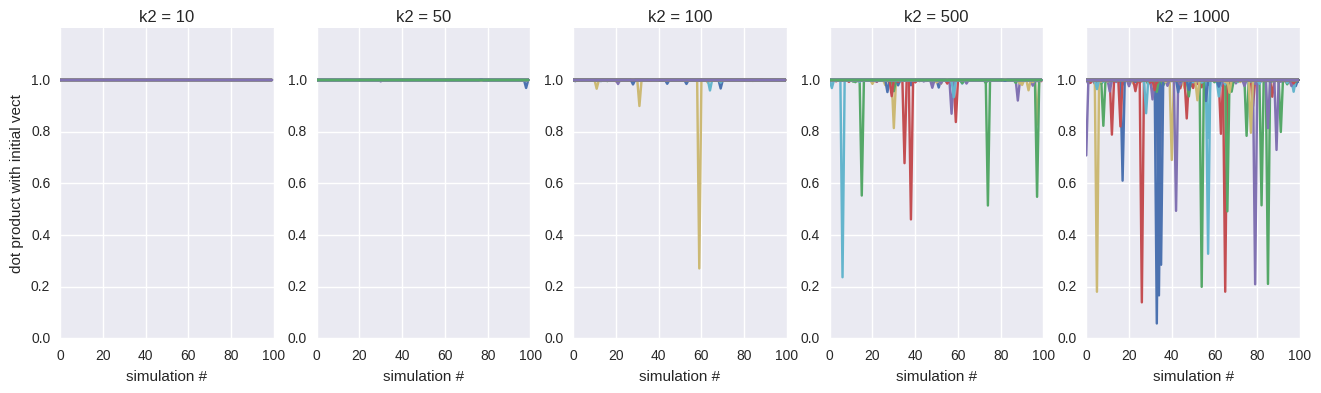

In [7]:
# First check to make sure final weights are aligned with initial weights

def check_to_see_if_col_are_same_line(X1,X2,verbose=True):
    u1 = X1 / np.linalg.norm(X1,axis=0)
    u2 = X2 / np.linalg.norm(X2,axis=0)
    dot_products = np.abs(np.diag(np.dot(u1.T,u2)))
    if verbose:
        for i in dot_products: print(i)
        if np.all(np.isclose(dot_products,1)):
            print('columns along same line')
        else:
            print('columns not along same line')            
    return dot_products

# Get initial weights
all_w_inits = {k2:[] for k2 in list_k2}
for i,k2 in enumerate(list_k2):
    for t in range(num_sims):
        seed = (k2-1)*num_sims+t
        w_init = pnn_initialize_weights(d,k2,seed=seed+1)
        all_w_inits[k2].append(w_init)

# First,investigate how close the final weights are to the initial weights
all_dot_products = {k2:[] for k2 in list_k2}
for i,k2 in enumerate(list_k2):
    for t in range(num_sims):
        w1 = outputs[k2][t][2]['weights1']
        w2 = all_w_inits[k2][t]['weights1']
        all_dot_products[k2].append(check_to_see_if_col_are_same_line(w1,w2,verbose=False))
        
plt.figure(figsize=(16,4))
for i,k2 in enumerate(list_k2):
    plt.subplot(1,5,i+1)
    plt.plot(all_dot_products[k2])
    plt.ylim(0,1.2)
    plt.title('k2 = %s'%(k2))
    plt.xlabel('simulation #')
    if i == 0:
        plt.ylabel('dot product with initial vect')

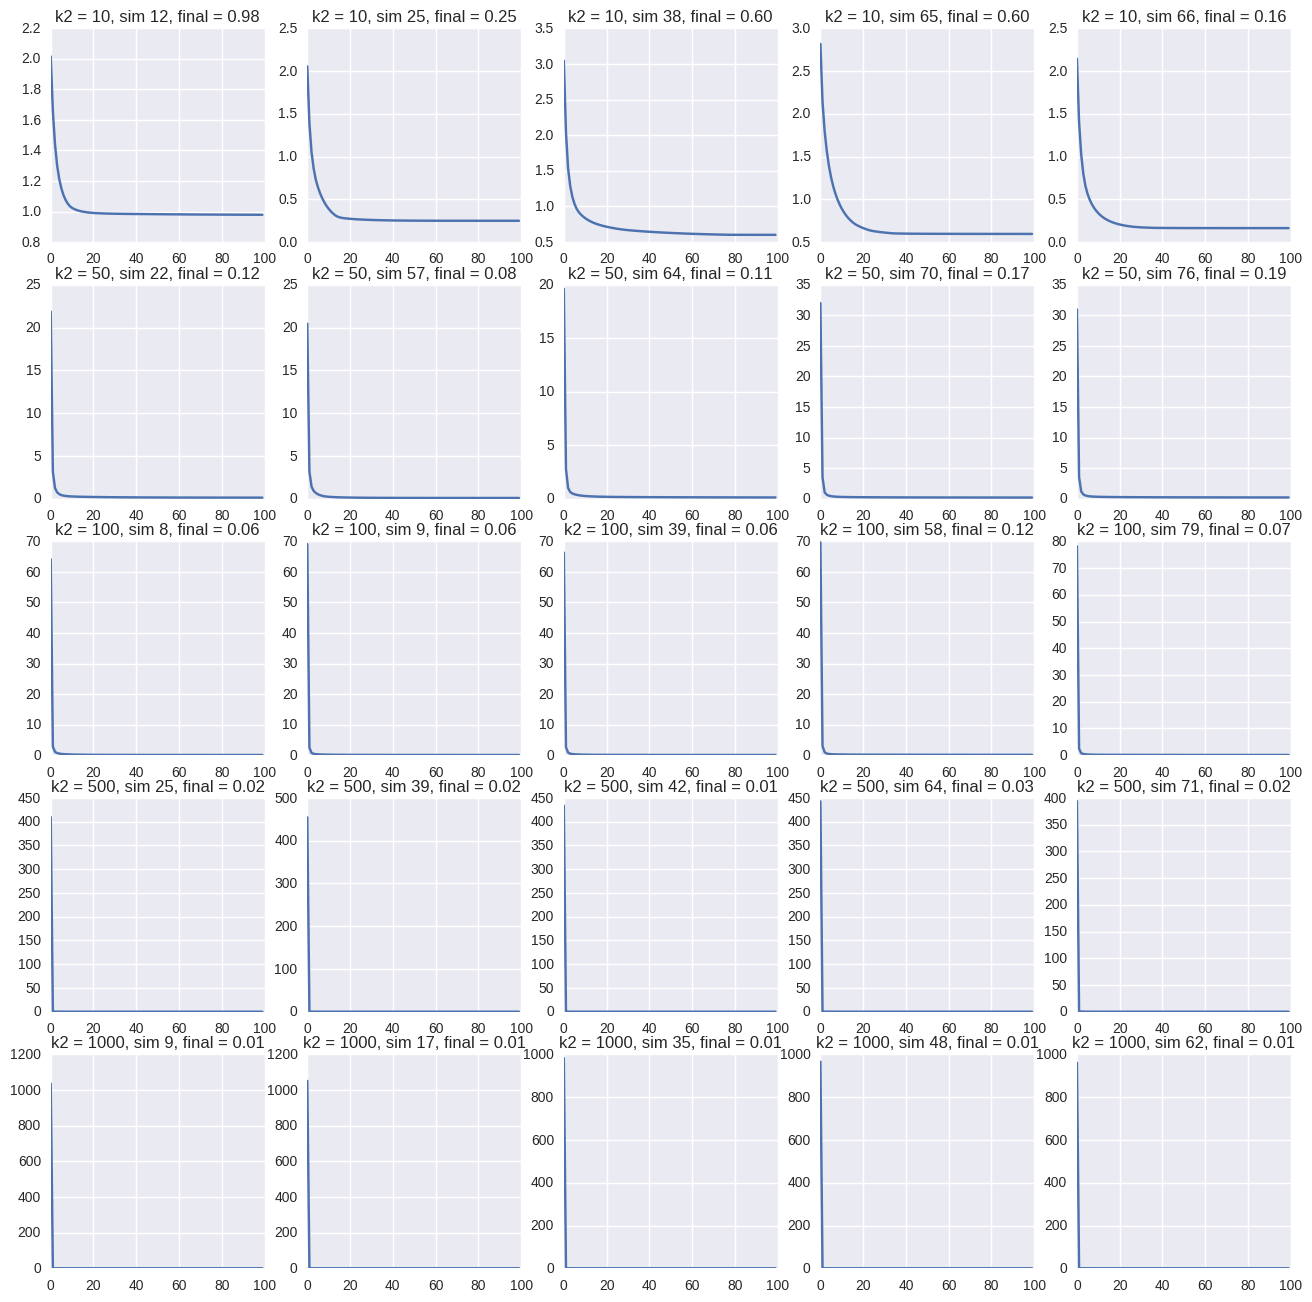

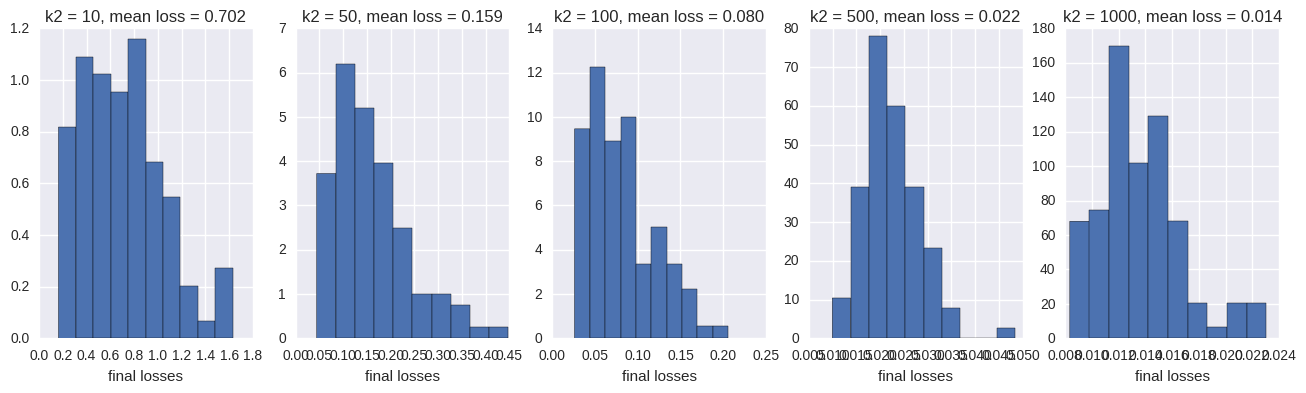

In [8]:
# Look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for k2 in list_k2:
    for j in np.sort(np.random.choice(range(num_sims),5,replace=False)):
        plt.subplot(len(list_k2),5,ind)
        plt.plot(outputs[k2][j][0])
        plt.title('k2 = %s, sim %s, final = %.2f'%(k2,j,outputs[k2][j][0][-1]))
        ind += 1
    
plt.figure(figsize=(16,4))
for j,k2 in enumerate(list_k2):
    final_losses = np.array([outputs[k2][i][-2] for i in range(num_sims)])
    plt.subplot(1,5,j+1)
    plt.hist(final_losses,normed=True)
    plt.title('k2 = %s, mean loss = %.3f'%(k2,np.mean(final_losses)))
    plt.xlabel('final losses')

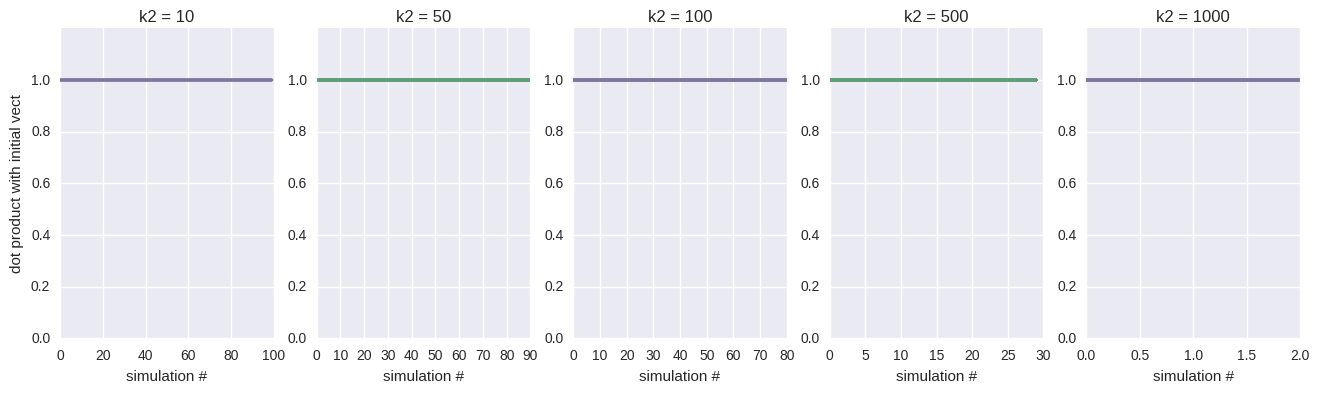

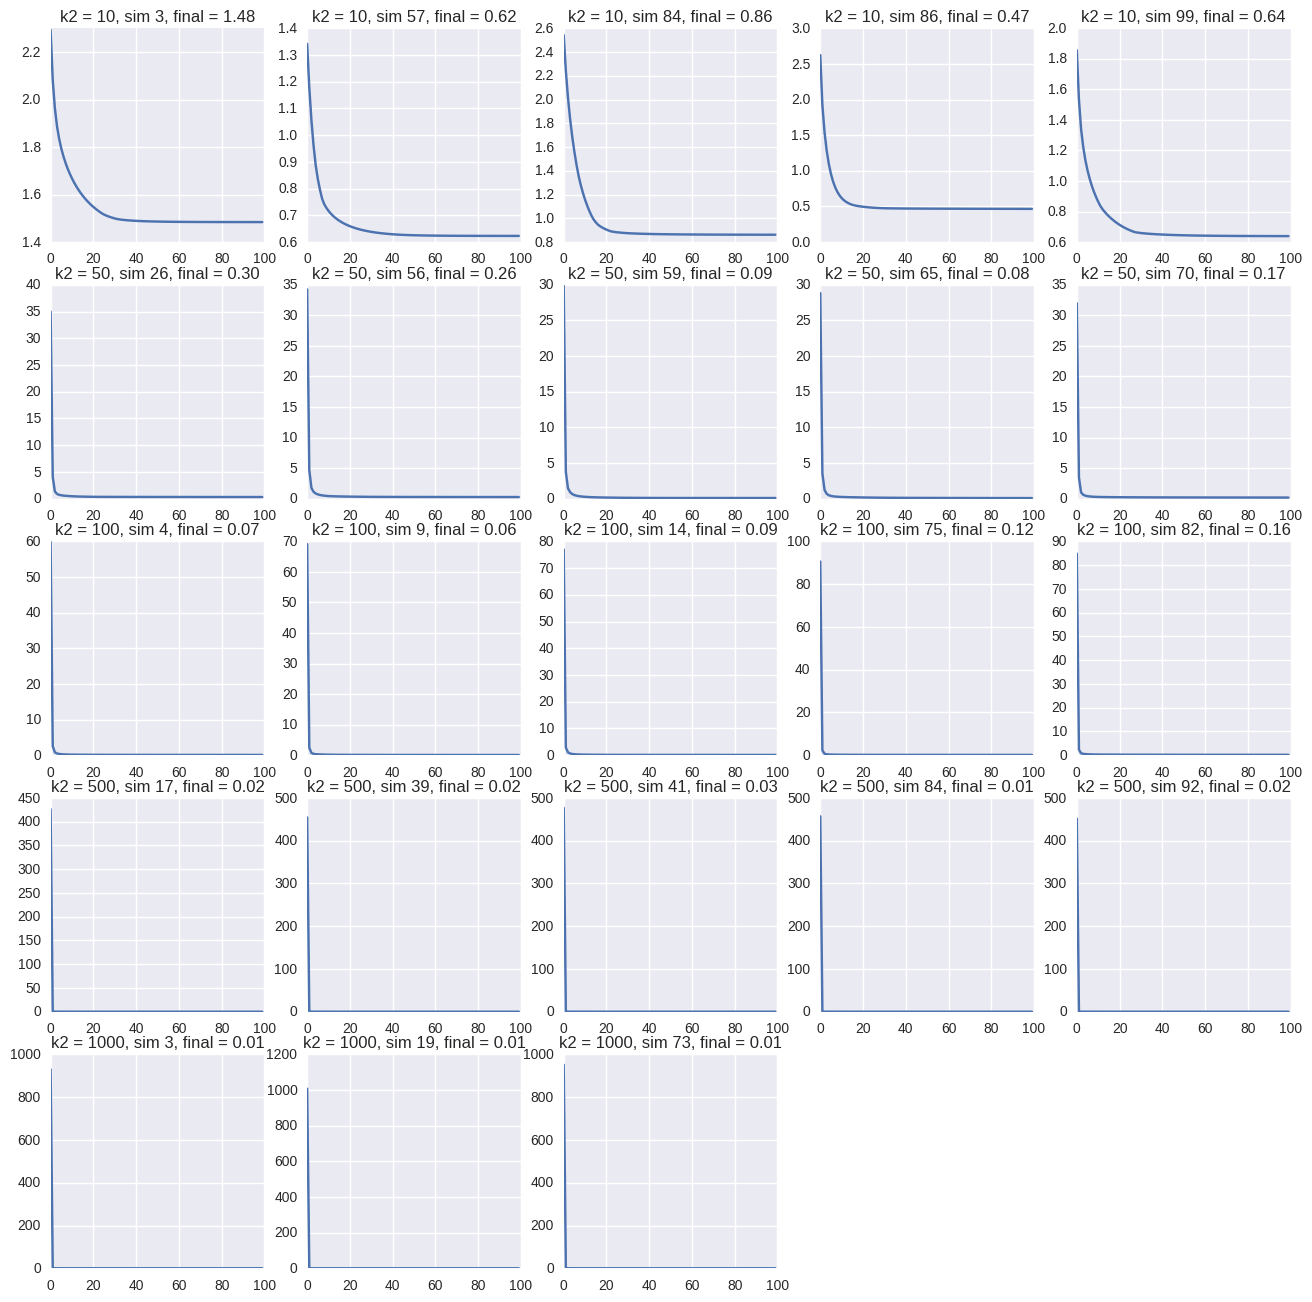

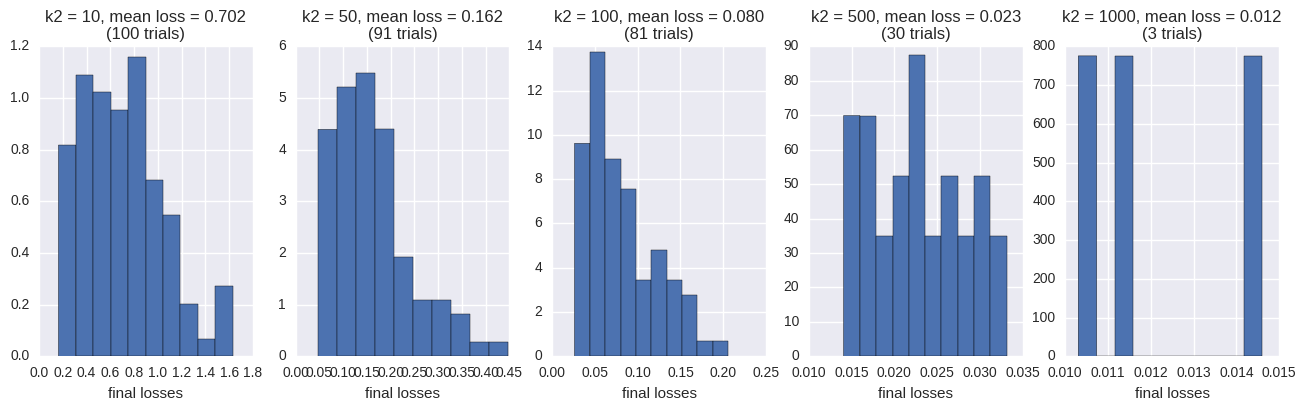

In [9]:
# Redo above except filter out cases where final weights aren't quite on original lines..

# First,investigate how close the final weights are to the initial weights
all_dot_products = {k2:[] for k2 in list_k2}
bad_optima = {k2:np.ones(num_sims).astype(bool) for k2 in list_k2}
for i,k2 in enumerate(list_k2):
    for t in range(num_sims):
        w1 = outputs[k2][t][2]['weights1']
        w2 = all_w_inits[k2][t]['weights1']
        all_dot_products[k2].append(check_to_see_if_col_are_same_line(w1,w2,verbose=False))
        if not np.all(np.isclose(all_dot_products[k2][-1],np.ones(k2),atol=1e-3)):
            bad_optima[k2][t] = False

# Dot product for kept curves
plt.figure(figsize=(16,4))
for i,k2 in enumerate(list_k2):
    inds = bad_optima[k2]
    plt.subplot(1,5,i+1)
    plt.plot(np.array(all_dot_products[k2])[inds])
    plt.ylim(0,1.2)
    plt.title('k2 = %s'%(k2))
    plt.xlabel('simulation #')
    if i == 0:
        plt.ylabel('dot product with initial vect')            

# Look at some random training curves to make sure we've converged
plt.figure(figsize=(16,16))
ind = 1
for k2 in list_k2:
    inds = bad_optima[k2]
    for j in np.sort(np.random.choice(np.where(inds)[0],np.min([5,np.sum(inds)]),replace=False)):
        plt.subplot(len(list_k2),5,ind)
        plt.plot(outputs[k2][j][0])
        plt.title('k2 = %s, sim %s, final = %.2f'%(k2,j,outputs[k2][j][0][-1]))
        ind += 1
            
plt.figure(figsize=(16,4))
for j,k2 in enumerate(list_k2):
    final_losses = np.array([outputs[k2][i][-2] for i in range(num_sims)])
    final_losses = final_losses[bad_optima[k2]]
    plt.subplot(1,5,j+1)
    plt.hist(final_losses,normed=True)
    plt.title('k2 = %s, mean loss = %.3f\n(%s trials)'
              %(k2,np.mean(final_losses),np.sum(bad_optima[k2])))
    plt.xlabel('final losses')

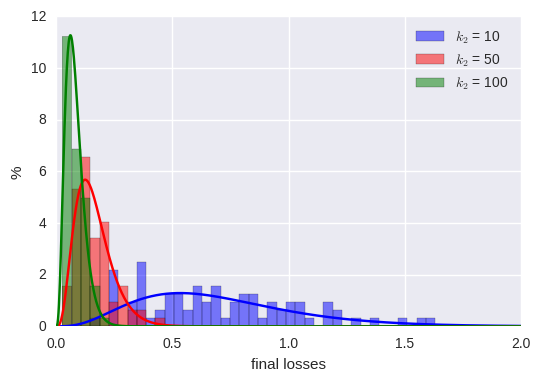

In [22]:
# Look at k2 = 10, 50, 100 cases

def fit_gamma(data,xmax):
    x = np.linspace(0, xmax, 1000)
    param = gamma.fit(data, floc=0)
    return gamma.pdf(x, *param)

list_k2 = [10,50,100]

values = []
for j,k2 in enumerate(list_k2):
    final_losses = np.array([outputs[k2][i][-2] for i in range(num_sims)])
    final_losses = final_losses[bad_optima[k2]]
    values.append(final_losses[:80])
    
colors = ['b','r','g']
bins=np.histogram(np.hstack(values), bins=40)[1] #get the bin edges
for j,i in enumerate(values):
    plt.hist(i, bins, label='$k_2$ = %s'%(list_k2[j]), color = colors[j], alpha = 0.5, normed=True)
    curve = fit_gamma(i,2)
    plt.plot(np.linspace(0, 2, 1000),curve,c=colors[j])
plt.legend()
plt.xlabel('final losses')
plt.ylabel('%')
plt.savefig('Figures/fig2.png', format='png', dpi=500, bbox_inches='tight')